In [1]:
%cd ..

/home/jairo/Documentos/GitHub/kink-antikink-parellel


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool, Lock
from os import cpu_count
from dataclasses import dataclass
from time import time
from pathlib import Path
from functools import partial

from modules.numerical import Diff, Lattice

In [3]:
class RKSolver:
    def __init__(self, F, y0, dt, t0=0):
        self.dt = dt
        self.F = F
        self._y = [y0]
        self._t = [t0]

    def step(self):
        t = self._t[-1]
        y = self._y[-1]
        dt = self.dt

        k1 = self.F(t, y)
        k2 = self.F(t + dt/2, y + k1*dt/2)
        k3 = self.F(t + dt/2, y + k2*dt/2)
        k4 = self.F(t + dt, y + k3*dt)

        self._y.append(
            y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        )
        self._t.append(t + dt)

    def run_util(self, T):
        while self._t[-1] < T:
            self.step()

    @property
    def y(self):
        return np.stack(self._y)

    @property
    def t(self):
        return np.stack(self._t)

@dataclass
class Kink:
    x0: float
    v: float
    lamb: float

    def __post_init__(self):
        gamma = 1/(1 - self.v**2)**0.5
        delta = (2/self.lamb)**0.5
        self._c = gamma/delta

    def z(self, x, t):
        return self._c*(x - self.x0 - self.v*t)
    
    def __call__(self, x, t):
        return np.tanh(self.z(x, t))
    
    def dt(self, x, t):
        return -self._c*self.v/np.cosh(self.z(x, t))**2
    
    def initial_config(x, lamb, x0s, vs, gnd=-1):
        y0 = np.zeros((2, x.shape[0]))
        y0[0].fill(gnd)
        for i, j in enumerate(np.argsort(x0s)):
            q = gnd*(-1)**(i + 1)
            k = Kink(x0s[j], vs[j], lamb)
            y0[0] += q*k(x, t=0)
            y0[1] += q*k.dt(x, t=0)
        return y0

class Lattice:
    def __init__(self, **axes):
        self.axes = axes
        self.ranges = {kw:np.arange(xl, xr, dx) for kw, (xl, xr, dx) in axes.items()}
    
    def __getattr__(self, kw):
        return self.ranges[kw]
    
    def __getitem__(self, axis):
        return self.ranges[axis]
    
    @property
    def shape(self):
        return tuple(map(len, self.ranges.values()))
    
    @property
    def grid(self):
        return np.stack(np.meshgrid(*tuple(self.ranges.values())), axis=-1)
    
    def at(self, **locs):
        kws = tuple(locs.keys())
        return [
            np.abs(X - locs[kw]).argmin() if kw in kws else Ellipsis 
            for kw, X in self.ranges.items()
        ]
    
    def window(self, **lims):
        kws = tuple(lims.keys())
        return [
            slice(np.abs(X - lims[kw][0]).argmin(), 
                  np.abs(X - lims[kw][1]).argmin())
            if kw in kws else Ellipsis 
            for kw, X in self.ranges.items()
        ]

@dataclass
class KinkCollisor:
    lattice: Lattice
    x0s: tuple[float]
    path: str|Path = None

    def __post_init__(self):
        self.diff = Diff(2, len(self.lattice.x), 5, self.lattice.axes['x'][-1])
    
    def F(self, t, Y, lamb):
        y, dy_dt = Y
        return np.stack((
            dy_dt, # = y'
            self.diff(y) + lamb*y*(1 - y**2) # = y''
        ))
    
    def collide(self, vs: tuple[float], lamb: float):
        y0 = Kink.initial_config(self.lattice.x, lamb, self.x0s, vs, gnd=-1)
        solver = RKSolver(partial(self.F, lamb=lamb), y0, self.lattice.axes['t'][-1], t0=self.lattice.t[0])
        solver.run_util(self.lattice.t[-1])
        return solver.y[:, 0]
    
    def run_an_save(self, v, lamb=1, expt=1000, verbose=True):
        save_path = self.path/f'{v}-{lamb}.csv'
        if not save_path.exists():
            y0 = Kink.initial_config(self.x, lamb, (-x0, x0), (v, -v), gnd=-1)

            solver = RKSolver(partial(self.F, lamb=lamb), y0, self.dt, t0=0)
            solver.run_util(self.x0/v + 2*self.L)

            df = pd.DataFrame({
                'y_cm': solver.y[:, 0, self.cm_index],
                'k': [self.x[np.argmin(np.abs(y[self.cm_index:]))] for y in solver.y[:, 0]]
            }, index=solver.t.astype('str'))

            global locker
            if locker != None:
                with locker: 
                    df.to_csv(save_path)
                    if verbose: print(len(list(self.path.glob('*')))*100/expt)
            else:
                df.to_csv(save_path)


In [6]:
L = 40
N = 1000
dt_dx = 0.7
x0 = 10

global locker
locker = Lock()
collisor = KinkCollisor(L, N, dt_dx, x0, path=Path('data/dataset2'))

In [9]:
V = np.linspace(0.1, 0.3, 2000)
np.random.shuffle(V)

with Pool(processes=cpu_count()) as pool:
    pool.map(partial(collisor.run_an_save, lamb=1, expt=2000, verbose=True), V)

5.55
5.6
5.65
5.7
5.75
5.8
5.85
5.9
5.95
6.0
6.05
6.1
6.15
6.2
6.25
6.3
6.35
6.4
6.45
6.5
6.55
6.6
6.65
6.7
6.75
6.8
6.85
6.9
6.95
7.0
7.05
7.1
7.15
7.2
7.25
7.3
7.35
7.4
7.45
7.5
7.55
7.6
7.65
7.7
7.75
7.8
7.85
7.9
7.95
8.0
8.05
8.1
8.15
8.2
8.25
8.3
8.35
8.4
8.45
8.5
8.55
8.6
8.65
8.7
8.75
8.8
8.85
8.9
8.95
9.0
9.05
9.1
9.15
9.2
9.25
9.3
9.35
9.4
9.45
9.5
9.55
9.6
9.65
9.7
9.75
9.8
9.85
9.9
9.95
10.0
10.05
10.1
10.15
10.2
10.25
10.3
10.35
10.4
10.45
10.5
10.55
10.6
10.65
10.7
10.75
10.8
10.85
10.9
10.95
11.0
11.05
11.1
11.15
11.2
11.25
11.3
11.35
11.4
11.45
11.5
11.55
11.6
11.65
11.7
11.75
11.8
11.85
11.9
11.95
12.0
12.05
12.1
12.15
12.2
12.25
12.3
12.35
12.4
12.45
12.5
12.55
12.6
12.65
12.7
12.75
12.8
12.85
12.9
12.95
13.0
13.05
13.1
13.15
13.2
13.25
13.3
13.35
13.4
13.45
13.5
13.55
13.6
13.65
13.7
13.75
13.8
13.85
13.9
13.95
14.0
14.05
14.1
14.15
14.2
14.25
14.3
14.35
14.4
14.45
14.5
14.55
14.6
14.65
14.7
14.75
14.8
14.85
14.9
14.95
15.0
15.05
15.1
15.15
15.2
15.25
15.3
15.35
15.4


In [54]:
L = 50
N = 1000
dx = 2*L/N
dt = dx*0.7
x0 = 2
lamb = 5

lat = Lattice(x=(-L, L, dx), t=(0, 150, dt))
collisor = KinkCollisor(lat, (-x0, x0))

In [55]:
y = collisor.collide((0, 0), lamb=lamb)

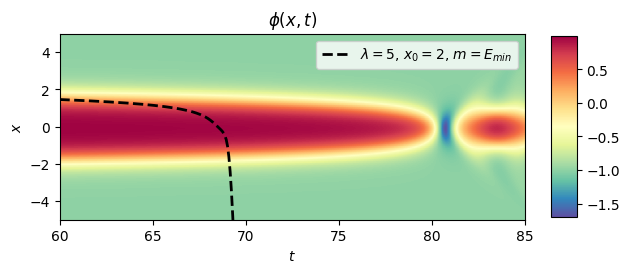

In [115]:
plt.imshow(y.T, cmap='Spectral_r', aspect=1, extent=(lat.t.min(), lat.t.max(), lat.x.min(), lat.x.max()))

# T, a = [], []
# for i, yp in enumerate(y >= 0):
#     try:
#         a.append(lat.x[yp].max())
#     except: break
#     else: T.append(lat.t[i])
# plt.plot(T, a, 'k--')

delta = np.sqrt(2/lamb)
m = 4*(lamb)**0.5/3
def F(t, Y):
    a, da = Y
    return np.stack((
        da,
        -(lamb/2)*((2*np.tanh(a/delta) - 1)**2 - 1)**2/m
    ))

solver = RKSolver(F, np.r_[x0, 0], dt, t0=lat.t.min())
solver.run_util(lat.t.max())

plt.plot(solver.t, solver.y[:, 0], 'k--', lw=2, label=r'$\lambda = {}$, $x_0 = {}$, '.format(lamb, x0) + '$m = E_{min}$')
plt.xlim(65, 90)
plt.ylim(-5, 5)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'$\phi(x, t)$')
plt.legend()
plt.colorbar(fraction=0.05, aspect=7)

plt.ylim(-5, 5)
plt.xlim(60, 85)

plt.gcf().tight_layout()

In [117]:
delta = np.sqrt(2/lamb)
def F(t, Y, m):
    a, da = Y
    return np.stack((
        da,
        -(lamb/2)*((2*np.tanh(a/delta) - 1)**2 - 1)**2/m
    ))

M0 = [lamb]
dM = 1
for _ in range(10):
    M = np.linspace(M0[-1] - dM, M0[-1] + dM, 20)
    Js = []
    for m in M:
        solver = RKSolver(partial(F, m=m), np.r_[x0, 0], dt, t0=0)
        solver.run_util(lat.t.max())

        Js.append(sum((y[j, *lat.at(x=a)]**2 for j, a in enumerate(solver.y[:, 0]) if a >= 0)))
    M0.append(M[np.argmin(Js)])
    dM /= 10

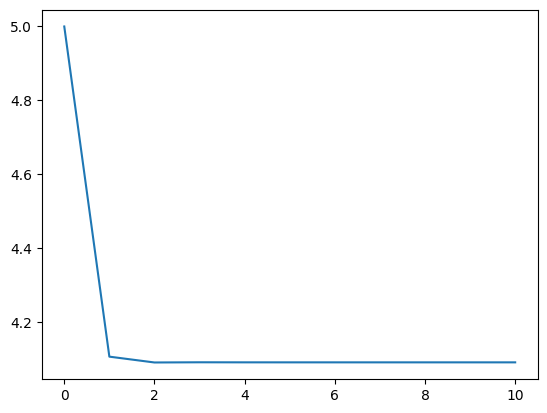

In [60]:
plt.plot(M0)

In [50]:
M0[-1]

1.1225521112105261

In [14]:
2*(2*5)**0.5/3

2.1081851067789197

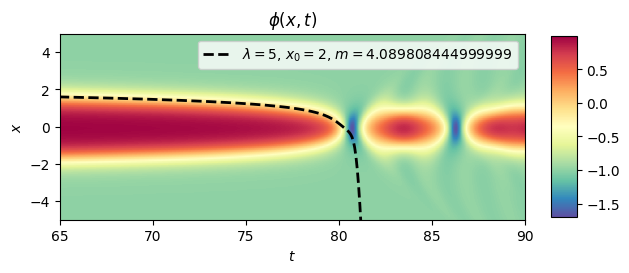

In [118]:
solver = RKSolver(partial(F, m=M0[-1]), np.r_[x0, 0], dt, t0=0)
solver.run_util(lat.t.max())
plt.imshow(y.T, cmap='Spectral_r', aspect=1, extent=(lat.t.min(), lat.t.max(), lat.x.min(), lat.x.max()))
# plt.plot(solver.t, solver.y[:, 0], 'w-', lw=4)
plt.plot(solver.t, solver.y[:, 0], 'k--', lw=2, label=r'$\lambda = {}$, $x_0 = {}$, $m = {}$'.format(lamb, x0, M0[-1]))
plt.xlim(65, 90)
plt.ylim(-5, 5)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'$\phi(x, t)$')
plt.legend()
plt.colorbar(fraction=0.05, aspect=7)
plt.gcf().tight_layout()
plt.show()

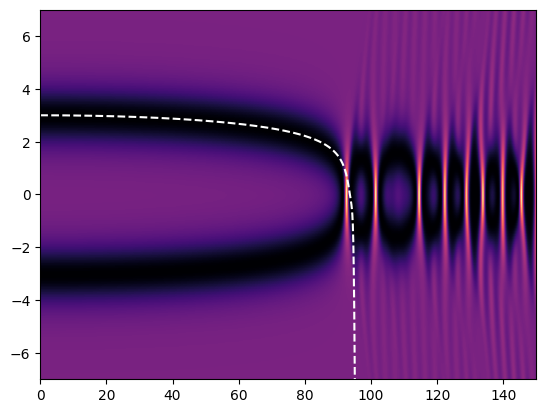

In [145]:
solver = RKSolver(partial(F, m=4*lamb/3), np.r_[x0, 0], dt, t0=0)
solver.run_util(lat.t.max())
plt.imshow((y[:, w].T)**2, cmap='magma', aspect='auto', extent=(lat.t.min(), lat.t.max(), -7, 7))
plt.plot(solver.t, solver.y[:, 0], 'w--')
plt.xlim(lat.t.min(), lat.t.max())
plt.ylim(-7, 7)
plt.show()

In [143]:
4*(2*lamb)**0.5/3, 4*lamb/3

(2.6666666666666665, 2.6666666666666665)

In [19]:
from celluloid import Camera
from IPython.display import HTML

def show(animation):
    plt.close()
    return HTML(animation.to_html5_video())

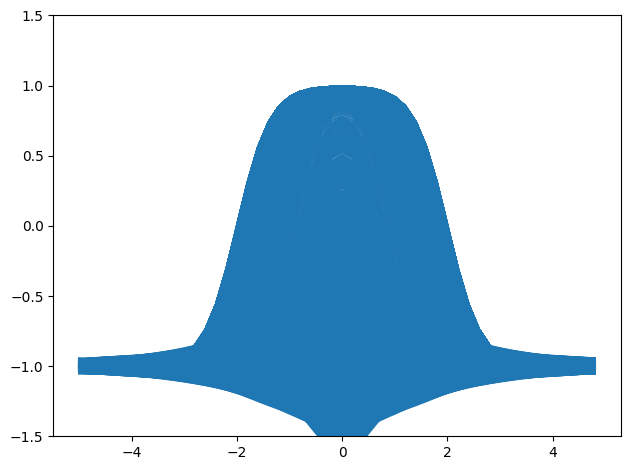

In [22]:
fig, ax = plt.subplots()
# ax.set_aspect(20)
fig.tight_layout()
ax.set_ylim(-1.5, 1.5)

camera = Camera(fig)
for y in solver.y[:, 0, *w]:
    ax.plot(lat[0][w], y, 'C0-')
    camera.snap()

In [23]:
show(camera.animate(interval=10))

In [18]:
%%time
v = 0.2
x0 = 5
lamb = 2
sol = KinkAntikink(grid, x0, v, lamb, grid.dx*0.7)
sol.run_util(x0/v + grid.xr)

CPU times: user 2.79 s, sys: 3.4 s, total: 6.19 s
Wall time: 904 ms


/tmp/ipykernel_6369/1841340699.py:9: RuntimeWarning: All-NaN slice encountered
  K1 = np.nanmax(X, axis=1)
/tmp/ipykernel_6369/1841340699.py:10: RuntimeWarning: All-NaN slice encountered
  K2 = np.nanmin(X, axis=1)


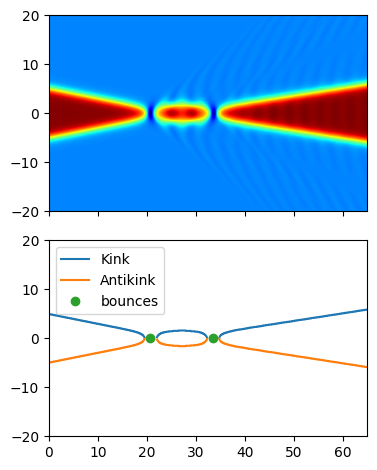

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

w = grid.window(-20, 20)
ax1.imshow(sol.y[:, w].T, extent=(sol.t[0], sol.t[-1], -20, 20), aspect='equal', origin='lower', cmap='jet')

X, _ = np.meshgrid(grid.x[w], sol.t)
X = np.where(sol.y[:, w] > 0, X, np.nan)
K1 = np.nanmax(X, axis=1)
K2 = np.nanmin(X, axis=1)

y = sol.y[:, grid.at(0)]**2
peaks, _ = find_peaks(y, prominence=1.5)
bounces = np.argsort(y[peaks])

ax2.plot(sol.t, K1, label='Kink')
ax2.plot(sol.t, K2, label='Antikink')
ax2.plot(sol.t[peaks][bounces], np.zeros(bounces.shape), 'o', label='bounces')
ax2.set_aspect('equal')
ax2.set_ylim(-20, 20)
ax2.legend()

fig.tight_layout()
plt.show()

In [24]:
X*loc

array([[-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.]])

ValueError: x and y must have same first dimension, but have shapes (1162,) and (500,)

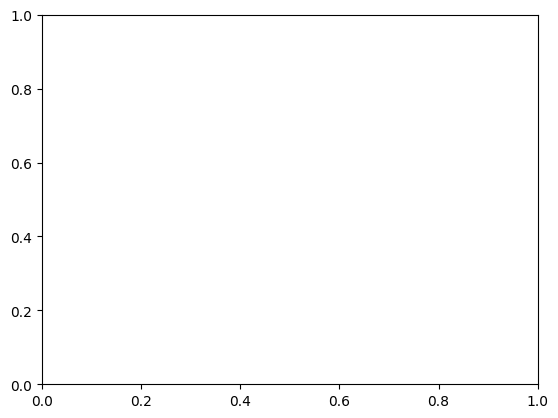

In [30]:
X, _ = np.meshgrid(grid.x[w], sol.t)
loc = sol.y[:, w] > 0
k1, k2 = [], []
for i in range(loc.shape[1]):
    ux = X[:, i]*loc[:, i]
    k1.append(ux.max())
    k2.append(ux.min())
plt.plot(sol.t, k1, sol.t, k2)

0.1544640179407925


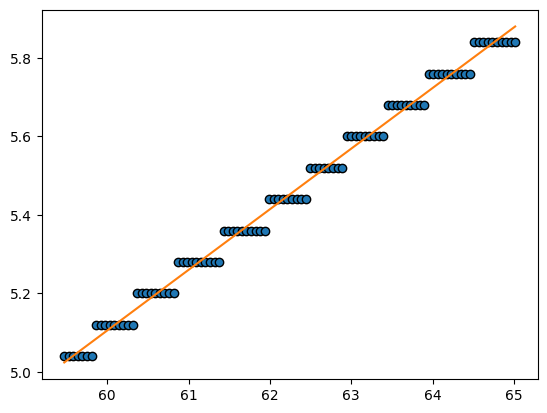

In [45]:
t, x = sol.t[-100:], K1[-100:]
(a, b), _ = curve_fit(lambda t, a, b: a*t + b, t, x)
plt.plot(t, x, 'o', markeredgecolor='k')
plt.plot(t, a*t + b)
print(a)

-0.20104191633147964


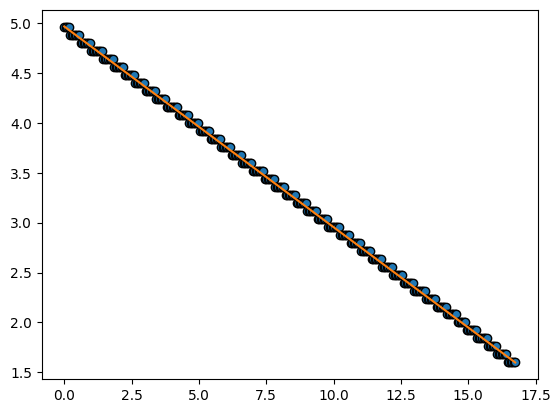

In [49]:
t, x = sol.t[:300], K1[:300]
(a, b), _ = curve_fit(lambda t, a, b: a*t + b, t, x)
plt.plot(t, x, 'o', markeredgecolor='k')
plt.plot(t, a*t + b)
print(a)

In [100]:
/%%time
v = 0.2
x0 = 5
lamb = 15
sol = KinkAntikink(grid, x0, v, lamb, grid.dx*0.7)
sol.run_util(x0/v + grid.xr)

CPU times: user 18.4 s, sys: 27.6 s, total: 46.1 s
Wall time: 6.24 s


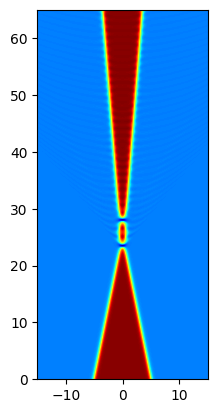

In [31]:
r, l = -15, 15
plt.imshow(sol.y[:, grid.window(r, l)], extent=(r, l, sol.t[0], sol.t[-1]), aspect='equal', origin='lower', cmap='jet')

In [ ]:
path = Path('../data/dataset/')
V = np.arange(0.1, 0.3, (0.3-0.1)/1000)
x0 = 5
lamb = 2

linear = lambda t, a, b: a*t + b
lock = Lock()
def collide(v):
    filename = path/f'lamb:{lamb}-v:{v}.csv'
    if not filename.exists():
        sol = KinkAntikink(grid, x0, v, lamb, grid.dx*0.7)
        sol.run_util(x0/v + grid.xr)
        pd.DataFrame(sol.y.T, columns=sol.t, index=grid.x).to_csv(filename)
        with lock:
            print(len(list(path.glob('*')))*100/1000)

with Pool(processes=cpu_count()-1) as pool:
    pool.map(collide, V)

25.5
25.6
25.8
25.8
25.8
25.9
25.9
26.1
26.1
26.3
26.5
26.6
26.6
26.7
26.7
26.8
26.9
27.1
27.1
27.5
27.5
27.5
27.5
27.7
27.8
28.2
28.2
28.2
28.2
28.2
28.4
28.5
28.8
28.9
28.9
28.9
28.9
29.1
29.1
29.3
29.3
29.6
29.6
29.6
30.1
30.1
30.2
30.2
30.3
30.3
30.3
30.5
30.9
30.9
30.9
31.0
31.0
31.0
31.2
31.2
31.5
31.7
31.7
31.7
31.7
31.8
31.9
32.2
32.2
32.4
32.5
32.5
32.5
32.8
32.8
32.9
32.9
33.1
33.1
33.2
33.5
33.5
33.6
33.6
33.8
34.0
34.1
34.2
34.2
34.2
34.4
34.6
34.6
34.7
34.8
34.8
35.1
35.1
35.2
35.3
35.4
35.4
35.5
35.6
35.9
36.1
36.1
36.2
36.2
36.2
36.3
36.7
36.7
36.8
36.8
36.9
37.0
37.0
37.1
37.5
37.5
37.6
37.6
37.6
37.8
37.8
38.0
38.1
38.3
38.3
38.3
38.4
38.5
38.8
39.0
39.0
39.1
39.1
39.1
39.2
39.4
39.6
39.6
39.6
39.8
39.8
39.9
40.1
40.3
40.3
40.4
40.4
40.7
40.8
40.8
40.8
40.9
41.1
41.1
41.3
41.3
41.6
41.8
41.8
41.8
41.8
41.9
42.2
42.2
42.4
42.5
42.5
42.6
42.6
42.8
42.8
43.2
43.2
43.2
43.3
43.3
43.5
43.6
43.7
43.9
43.9
44.0
44.1
44.2
44.3
44.3
44.4
44.8
45.0
45.0
45.0
45.0
45.0
45.1
45.5


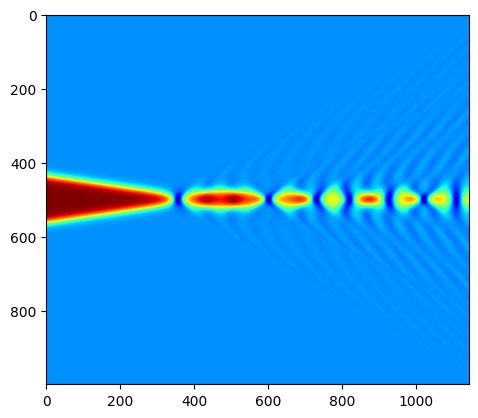

In [ ]:
files = tuple(path.glob('*'))
plt.imshow(pd.read_csv(files[0], index_col=0).values, cmap='jet')

In [ ]:
linear = lambda t, a, b: a*t + b
v_in, N_bounces = [], []
for i, file in enumerate(files):
    v_in.append(float(file.stem.split('-')[1].split(':')[1]))
    sol = pd.read_csv(file, index_col=0)
    y = sol.values[grid.at(0)]**2
    t = sol.columns.values.astype(float)
    x = sol.index.values.astype(float)
    peaks, _ = find_peaks(y, prominence=1.5)
    N_bounces.append(len(y[peaks]))
N_bounces = np.stack(N_bounces)[np.argsort(v_in)]
v_in = np.sort(v_in)

In [ ]:
N_bounces = np.stack(N_bounces)[np.argsort(v_in)]
v_in = np.sort(v_in)

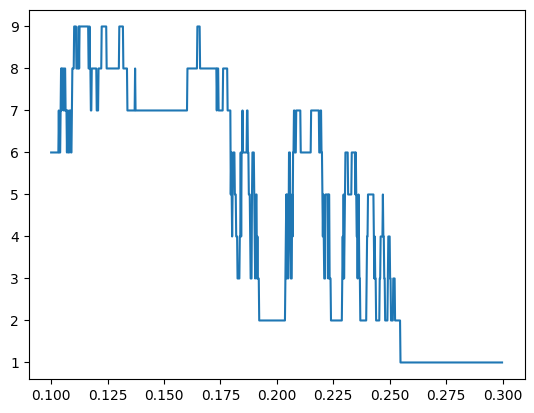

In [ ]:
plt.plot(v_in, N_bounces, '-')

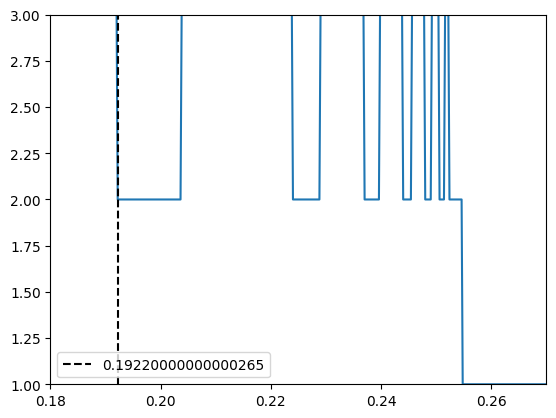

In [ ]:
plt.plot(v_in, N_bounces, '-')
plt.ylim(1, 3)
plt.xlim(0.18, 0.27)
v2_min = v_in[N_bounces == 2].min()
plt.vlines(v2_min, 1, 3, colors='k', linestyles='dashed', label=v2_min)
plt.legend()
plt.show()

(0.18, 0.27)

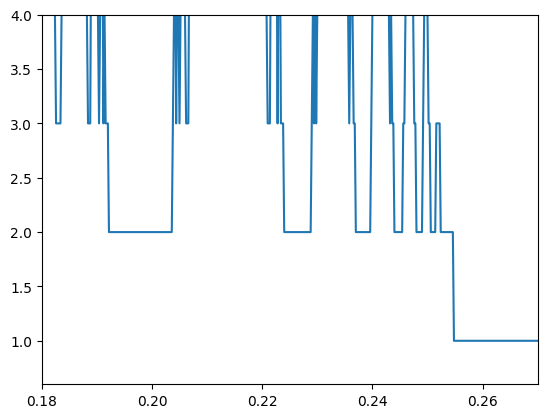

In [ ]:
plt.plot(v_in, N_bounces, '-')
plt.ylim(top=4)
plt.xlim(0.18, 0.27)

$$
2x_0 \gg \delta = \sqrt{2/\lambda}
$$

$$
4x_0^2 \gg 2/\lambda
$$

$$
\lambda \gg \frac{1}{2x_0^2} = \frac{1}{2(5)^2} = \frac{1}{50} = 0.02
$$

In [120]:
pd.DataFrame(solver.Y[:, 0], columns=grid.x[1:-1], index=solver.t)

,-39.92,-39.84,-39.76,-39.68,-39.60,-39.52,-39.44,-39.36,-39.28,-39.20,...,39.12,39.20,39.28,39.36,39.44,39.52,39.60,39.68,39.76,39.84
0.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.056,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.112,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.168,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.224,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64.792,-0.999979,-0.999965,-0.999963,-0.999971,-0.999986,-1.000004,-1.000017,-1.000026,-1.000028,-1.000025,...,-1.000042,-1.000040,-1.000025,-1.000003,-0.999984,-0.999973,-0.999973,-0.999980,-0.999989,-0.999996
64.848,-0.999997,-0.999991,-0.999983,-0.999976,-0.999975,-0.999985,-1.000002,-1.000023,-1.000037,-1.000039,...,-1.000039,-1.000034,-1.000014,-0.999990,-0.999974,-0.999974,-0.999987,-1.000004,-1.000015,-1.000012
64.904,-1.000015,-1.000019,-1.000009,-0.999991,-0.999977,-0.999975,-0.999988,-1.000010,-1.000029,-1.000034,...,-1.000016,-1.000011,-0.999997,-0.999983,-0.999979,-0.999988,-1.000007,-1.000024,-1.000030,-1.000021
64.960,-1.000023,-1.000034,-1.000029,-1.000011,-0.999991,-0.999979,-0.999981,-0.999993,-1.000006,-1.000011,...,-0.999982,-0.999980,-0.999981,-0.999986,-0.999997,-1.000011,-1.000024,-1.000031,-1.000029,-1.000017


In [5]:
from pathlib import Path
import pandas as pd
data_dir = Path('../data/mosaico')

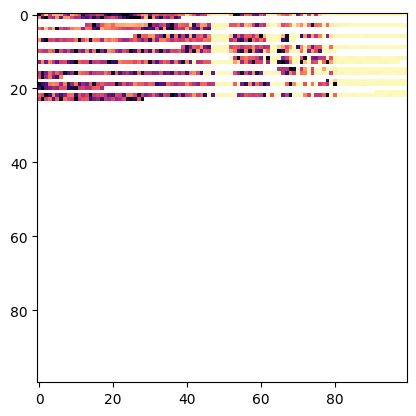

In [43]:
plt.imshow(pd.read_csv(data_dir/'mosaic.csv', index_col=0).values)

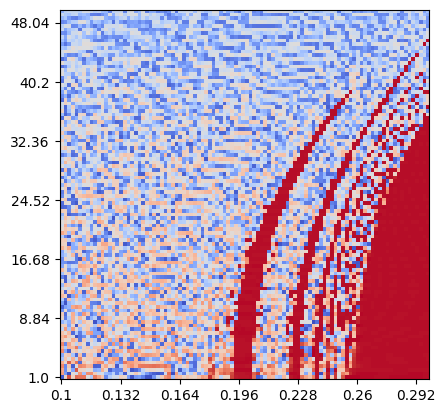

In [31]:
cm = pd.read_csv(data_dir/'mosaic.csv', index_col=0)
plt.imshow(cm.values, cmap='coolwarm', origin='lower')
plt.xticks(np.arange(0, cm.columns.size, cm.columns.size//6), cm.columns[::cm.columns.size//6].values.astype(float))
plt.yticks(np.arange(0, cm.index.size, cm.index.size//6), cm.index[::cm.index.size//6].values.astype(float))
plt.show()

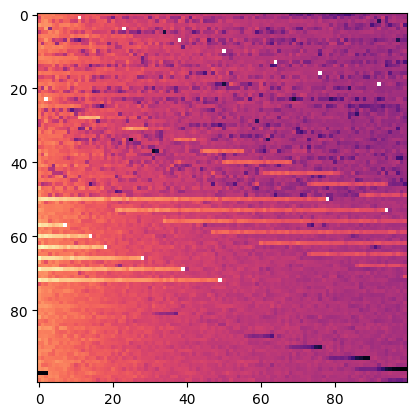

In [27]:
ex_time = pd.read_csv(data_dir/'exec_time.csv', index_col=0).values
plt.imshow(np.where(ex_time > np.nanmax(ex_time)*0.1, np.nan, ex_time))

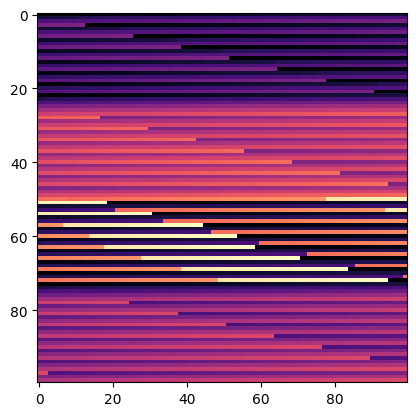

In [28]:
plt.imshow(pd.read_csv(data_dir/'ell_time.csv', index_col=0).values)

In [18]:
cm = pd.read_csv(data_dir/'mosaic.csv', index_col=0)
1 - cm.isnull().values.sum()/cm.size

0.9696